# Python MAGIC EMT tutorial

## MAGIC (Markov Affinity-Based Graph Imputation of Cells)

- MAGIC imputes missing data values on sparse data sets, restoring the structure of the data
- It also proves dimensionality reduction and gene expression visualizations
- MAGIC can be performed on a variety of datasets
- Here, we show the effectiveness of MAGIC on epithelial-to-mesenchymal transition (EMT) data
    
Markov Affinity-based Graph Imputation of Cells (MAGIC) is an algorithm for denoising and transcript recover of single cells applied to single-cell RNA sequencing data, as described in Van Dijk D et al. (2018), Recovering Gene Interactions from Single-Cell Data Using Data Diffusion, Cell https://www.cell.com/cell/abstract/S0092-8674(18)30724-4.

This tutorial shows loading, preprocessing, MAGIC imputation and visualization of myeloid and erythroid cells in mouse bone marrow. You can edit it yourself at https://colab.research.google.com/github/KrishnaswamyLab/MAGIC/blob/master/python/tutorial_notebooks/emt_tutorial.ipynb

### Table of Contents

<a href='#install'>Installation</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#magic'>Running MAGIC</a>
<br/>
<a href='#genes'>Visualizing gene-gene interactions</a>
<br/>
<a href='#manifold'>Visualizing cell trajectories with PCA on MAGIC</a>
<br/>
<a href='#postprocess'>Using MAGIC data in downstream analysis</a>

<a id="install"></a>

### Installation 

If you haven't yet installed MAGIC, we can install it directly from this Jupyter Notebook.

In [ ]:
!pip install --user magic-impute

### Importing MAGIC

Here, we'll import MAGIC along with other popular packages that will come in handy.

In [1]:
import magic
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

### Loading Data

Load your data using one of the following `scprep.io` methods: `load_csv`,`load_tsv`,`load_fcs`,`load_mtx`,`load_10x`. 

You can read about how to use them with `help(scprep.io.load_csv)` or on https://scprep.readthedocs.io/.

In [2]:
emt_data = scprep.io.load_csv('../../data/HMLE_TGFb_day_8_10.csv.gz')
emt_data.head()

,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,AACS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
5S_rRNA,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="data"></a>

### Data Preprocessing

The EMT example data we are using is already pre-filtered and nicely distributed, so we will only demonstrate these preprocessing steps, and not actually perform them on the data. However, these steps are essential for performing MAGIC on **single-cell RNA-seq data**, so don't skip them if that's what you're working with. 

#### Filtering your data

After loading your data, you're going to want to determine the molecule per cell and molecule per gene cutoffs with which to filter the data, in order to remove lowly expressed genes and cells with a small library size.

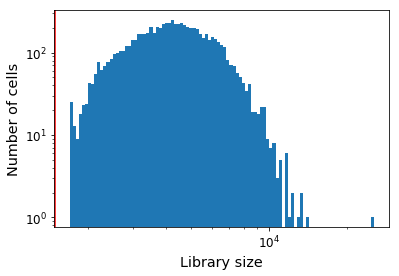

In [3]:
scprep.plot.plot_library_size(emt_data, cutoff=1500)

In [4]:
if False:
    emt_data = scprep.filter.filter_library_size(emt_data, cutoff=1500)
emt_data.head()

,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,AACS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
5S_rRNA,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Normalizing your data

After filtering, the next steps are to perform library size normalization and transformation. Log transformation is frequently used for single-cell RNA-seq, however, this requires the addition of a pseudocount to avoid infinite values at zero. We instead use a square root transform, which has similar properties to the log transform but has no problem with zeros.

In [5]:
emt_data = scprep.normalize.library_size_normalize(emt_data)
if False:
    emt_data = scprep.transform.sqrt(emt_data)
emt_data.head()

,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,AACS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
5S_rRNA,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.002377,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,1.34385,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.320702,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="magic"></a>

### Running MAGIC

Now that your data has been preprocessed, you are ready to run MAGIC.

#### Creating the MAGIC operator

If you don't specify any parameters, the following line creates an operator with the following default values: `knn=10`, `decay=15`, `t='auto'`.

In [6]:
magic_op = magic.MAGIC()

#### Running MAGIC with gene selection

The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with `genes='all_genes'`.

In [7]:
emt_magic = magic_op.fit_transform(emt_data, genes=['VIM', 'CDH1', 'ZEB1'])

Calculating MAGIC...
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 28.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.71 seconds.
    Calculating affinities...
    Calculated affinities in 0.80 seconds.
  Calculated graph and diffusion operator in 37.23 seconds.
  Calculating imputation...
    Automatically selected t = 7
  Calculated imputation in 1.11 seconds.
Calculated MAGIC in 42.53 seconds.


### Visualizing gene-gene relationships
<a id="genes"></a>

We can see gene-gene relationships much more clearly after applying MAGIC.

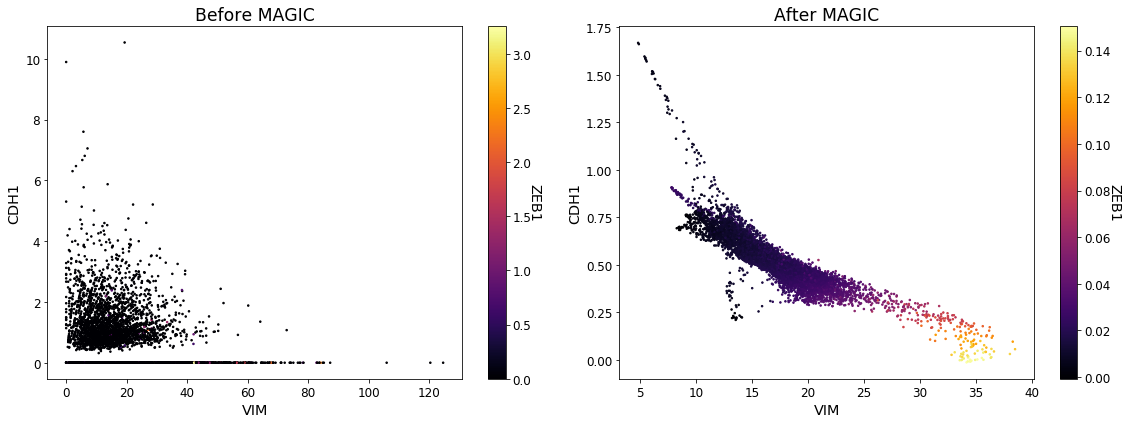

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=emt_data['VIM'], y=emt_data['CDH1'], c=emt_data['ZEB1'],  ax=ax1,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='Before MAGIC')

scprep.plot.scatter(x=emt_magic['VIM'], y=emt_magic['CDH1'], c=emt_magic['ZEB1'], ax=ax2,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='After MAGIC')

plt.tight_layout()
plt.show()

The original data suffers from dropout to the point that we cannot infer anything about the gene-gene relationships. As you can see, the gene-gene relationships are much clearer after MAGIC. These relationships also match the biological progression we expect to see in EMT data.

#### Setting the MAGIC operator parameters

If you did not specify any parameters for your MAGIC operator, you can do so without going through the hassle of creating a new one using the magic_op.set_params method. Since our example EMT dataset is rather large, we can set `knn=15`, rather than the default `knn=10`. 



In [9]:
magic_op.set_params(knn=15)

MAGIC(a=None, decay=15, k=None, knn=15, knn_dist='euclidean', n_jobs=1,
   n_pca=100, random_state=None, t='auto', verbose=1)

We can now run MAGIC on the data again with the new parameters. Given that we have already fitted our MAGIC operator to the data, we should run the magic_op.transform method.

In [10]:
emt_magic = magic_op.transform(genes=['VIM', 'CDH1', 'ZEB1'])
emt_magic.head()

Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 28.74 seconds.
  Calculating KNN search...
  Calculated KNN search in 7.15 seconds.
  Calculating affinities...
  Calculated affinities in 0.59 seconds.
Calculated graph and diffusion operator in 37.65 seconds.
Calculating imputation...
  Automatically selected t = 7
Calculated imputation in 1.43 seconds.


,CDH1,VIM,ZEB1
5S_rRNA,,,
0,0.470403,18.784235,0.020237
0,0.451725,17.344261,0.020527
0,0.450305,20.122767,0.024583
0,0.586277,14.206284,0.014772
0,0.441491,19.207618,0.021403


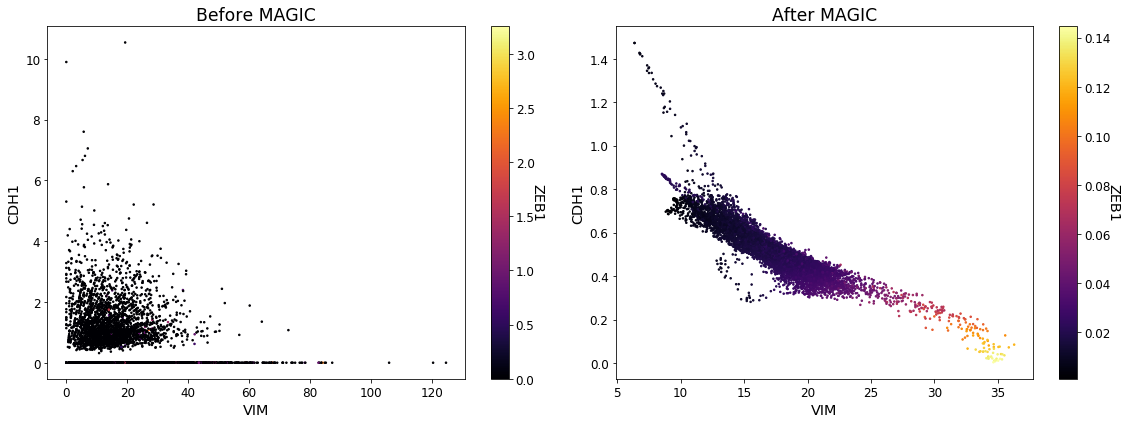

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=emt_data['VIM'], y=emt_data['CDH1'], c=emt_data['ZEB1'],  ax=ax1,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='Before MAGIC')

scprep.plot.scatter(x=emt_magic['VIM'], y=emt_magic['CDH1'], c=emt_magic['ZEB1'], ax=ax2,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='After MAGIC')

plt.tight_layout()
plt.show()

<a id="manifold"></a>

### Visualizing cell trajectories with PCA on MAGIC

We can extract the principal components of the smoothed data by passing the keyword `genes='pca_only'` and use this for visualizing the data.

In [12]:
emt_magic_pca = magic_op.transform(genes='pca_only')
emt_magic_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
5S_rRNA,,,,,,,,,,,,,,,,,,,,,
0,-0.437088,-12.977346,-4.750861,-4.987899,-0.581010,-3.260665,-0.817152,-0.042108,0.388692,-0.603703,...,0.000010,-0.001517,0.000971,-0.000800,-0.003599,-0.001516,-0.000140,-0.000020,0.002757,-0.002619
0,1.699831,20.654336,-28.553463,7.719823,1.849055,2.474168,-1.733318,-2.043647,0.240834,-0.668564,...,-0.007538,0.004732,0.000496,0.002009,-0.001354,-0.001376,-0.000625,0.000101,0.003736,0.003744
0,-7.736762,-22.280302,-0.835621,-4.993292,-0.919966,-3.344350,-0.152481,0.176580,0.873383,0.272685,...,-0.000927,0.000451,0.000457,0.001850,-0.003837,-0.001082,0.000006,0.001358,0.002388,-0.002387
0,-37.143482,49.156070,4.634911,2.181967,2.618592,1.205742,1.822116,0.536272,-0.818747,0.251041,...,-0.003240,-0.002535,0.007421,0.003452,-0.004696,0.004596,-0.000480,-0.004669,0.001309,0.001695
0,-6.673826,-14.287906,-11.027716,-3.396477,-0.023894,-2.057104,-0.685945,0.043513,0.853544,-0.937439,...,-0.001231,0.000113,-0.000325,0.000616,-0.006538,0.001258,-0.000930,-0.001577,0.001724,-0.001973


We'll also run PCA on the raw data to compare.

In [13]:
from sklearn.decomposition import PCA
emt_pca = PCA(n_components=3).fit_transform(np.array(emt_data))

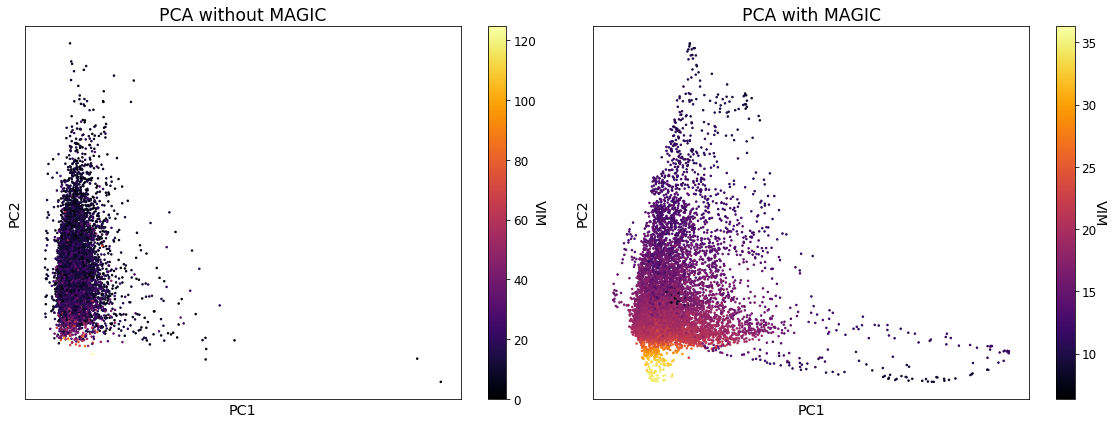

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter2d(emt_pca, c=emt_data['VIM'], 
                      label_prefix="PC", title='PCA without MAGIC',
                      legend_title="VIM", ax=ax1, ticks=False)

scprep.plot.scatter2d(emt_magic_pca, c=emt_magic['VIM'], 
                      label_prefix="PC", title='PCA with MAGIC',
                      legend_title="VIM", ax=ax2, ticks=False)

plt.tight_layout()
plt.show()

We can also plot this in 3D.

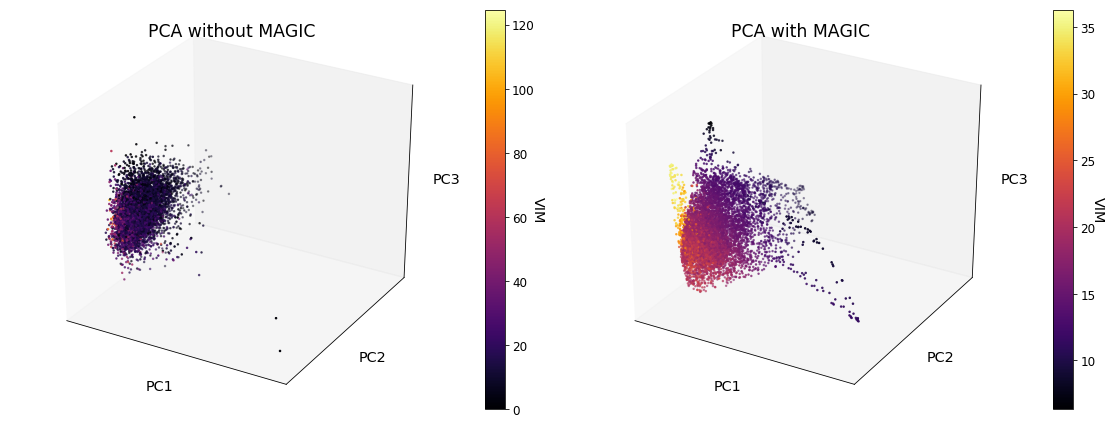

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), subplot_kw={'projection':'3d'})

scprep.plot.scatter3d(emt_pca, c=emt_data['VIM'], 
                      label_prefix="PC", title='PCA without MAGIC',
                      legend_title="VIM", ax=ax1, ticks=False)

scprep.plot.scatter3d(emt_magic_pca, c=emt_magic['VIM'], 
                      label_prefix="PC", title='PCA with MAGIC',
                      legend_title="VIM", ax=ax2, ticks=False)

plt.tight_layout()
plt.show()

### Visualizing MAGIC values with PHATE

In complex systems, two dimensions of PCA are not sufficient to view the entire space. For this, PHATE is a suitable visualization tool which works hand in hand with MAGIC to view how gene expression evolves along a trajectory. For this, you will need to have installed PHATE. For help using PHATE, visit https://phate.readthedocs.io/.

In [ ]:
!pip install --user phate

In [16]:
import phate

In [17]:
data_phate = phate.PHATE(knn=15, decay=15).fit_transform(emt_data)

Calculating PHATE...
  Running PHATE on 7523 cells and 28909 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 27.97 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.91 seconds.
    Calculating affinities...
    Calculated affinities in 0.53 seconds.
  Calculated graph and diffusion operator in 36.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.69 seconds.
    Calculating KMeans...
    Calculated KMeans in 23.85 seconds.
  Calculated landmark operator in 32.31 seconds.
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 3.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.39 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 36.40 seconds.
Calculated PHATE in 111.21 seconds.


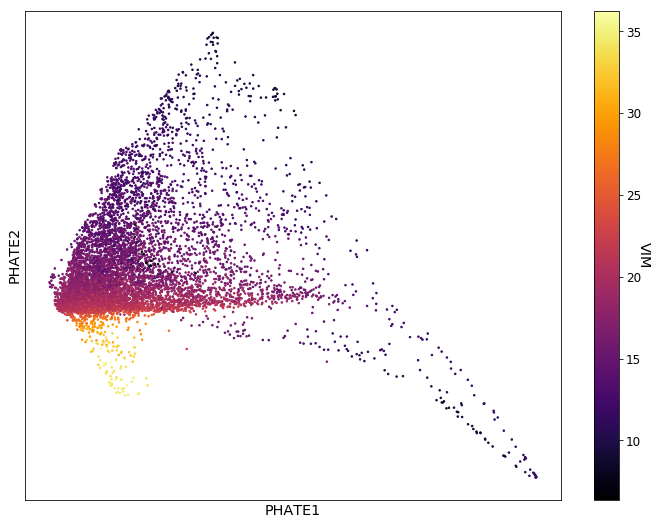

In [18]:
scprep.plot.scatter2d(data_phate, c=emt_magic['VIM'], figsize=(12,9),
                      ticks=False, label_prefix="PHATE", legend_title="VIM")

### Using the MAGIC smoothed data in downstream analysis
<a id="postprocess"></a>

Finally, if you wish to use the full smoothed matrix in any downstream analysis, you can extract it with the keyword `genes="all_genes"`. Note that this matrix may be very large.

In [19]:
emt_magic = magic_op.transform(genes="all_genes")
emt_magic.head()

,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,AACS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
5S_rRNA,,,,,,,,,,,,,,,,,,,,,
0,0.000260,0.001854,0.028587,0.000068,-0.000001,0.008294,-0.000029,0.012580,0.127611,0.220385,...,0.000100,0.244989,1.186780,0.001697,0.004436,0.000433,0.001329,0.000223,0.021398,0.000107
0,0.000184,0.001151,0.032717,0.000094,0.000146,0.010182,0.000043,0.006312,0.126887,0.216520,...,-0.000045,0.237556,1.164639,0.000568,0.004629,0.000169,0.001468,-0.000071,0.015731,-0.000102
0,0.000243,0.002097,0.026855,0.000056,-0.000032,0.008210,-0.000021,0.013524,0.127875,0.220955,...,0.000173,0.242813,1.187160,0.001906,0.004235,0.000457,0.001303,0.000278,0.022739,0.000129
0,-0.000062,0.003031,0.033760,0.000101,0.000465,0.019907,0.000232,0.017490,0.105298,0.232056,...,0.000224,0.216358,1.159305,0.000531,0.004011,0.000276,0.001395,0.000010,0.012521,0.000255
0,0.000244,0.001715,0.027644,0.000052,-0.000022,0.007139,-0.000031,0.010680,0.130529,0.219831,...,0.000107,0.241654,1.176363,0.001605,0.004367,0.000400,0.001444,0.000219,0.021477,0.000103
